In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import mutual_info_classif,chi2
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import roc_auc_score, mean_squared_error

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import CondensedNearestNeighbour

import category_encoders as ce

plt.style.use('seaborn-colorblind')
%matplotlib inline

In [2]:
data = pd.read_csv("./adult.data")
data.head()

,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [3]:
# нет именований колонок, возьмем из описания датасета:
headers = [
    "age", "workclass", "fnlwgt", "education", "education-num", 
    "marital-status", "occupation", "relationship", "race",
    "sex", "capital-gain", "capital-loss", "hours-per-week",
    "native-country", "makes_over_50K_a_year"
]
# и совершенно случайно заметим что разделитель = ", " а не ","
data = pd.read_csv("./adult.data", names=headers, sep=", ")
data.to_csv("feature_engineering.csv", sep=',')
data.head()

/home/pbedyaev/anaconda2/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:9: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,makes_over_50K_a_year
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
data.shape

(32561, 15)

In [5]:
# понравилась функция проверки пустых значений, скопировал
def check_missing(data,output_path=None):    
    result = pd.concat([data.isnull().sum(),data.isnull().mean()],axis=1)
    result = result.rename(index=str,columns={0:'total missing',1:'proportion'})
    if output_path is not None:
        result.to_csv(output_path+'missing.csv')
        print(output_path, 'missing.csv')
    return result

In [6]:
check_missing(data=data)

,total missing,proportion
age,0,0.0
workclass,0,0.0
fnlwgt,0,0.0
education,0,0.0
education-num,0,0.0
marital-status,0,0.0
occupation,0,0.0
relationship,0,0.0
race,0,0.0
sex,0,0.0


In [7]:
# вроде нет пустых значений
data.isnull().sum()

age                      0
workclass                0
fnlwgt                   0
education                0
education-num            0
marital-status           0
occupation               0
relationship             0
race                     0
sex                      0
capital-gain             0
capital-loss             0
hours-per-week           0
native-country           0
makes_over_50K_a_year    0
dtype: int64

In [8]:
# похоже что data["fnlwgt"] нужно выкинуть, без разбивки по штатам он бесполезен
data.drop("fnlwgt", axis=1, inplace=True)

In [9]:
not_null_columns = []
for j in data.select_dtypes(exclude=['object']).columns.values:
    not_null_columns.append(j)
print(not_null_columns)

['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']


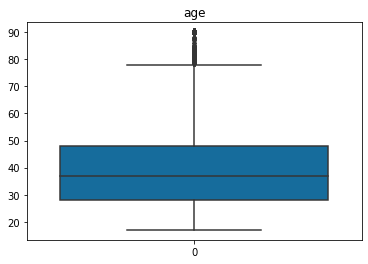

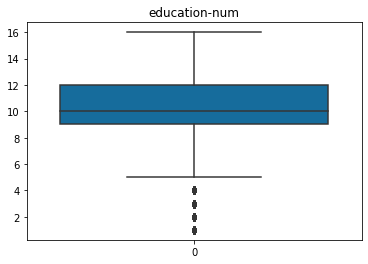

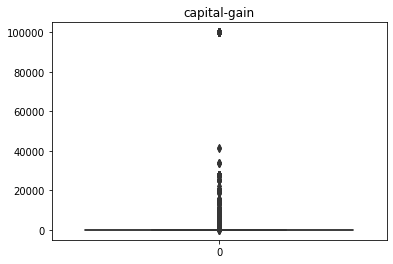

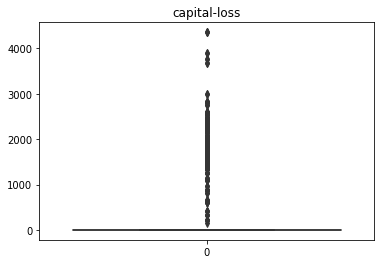

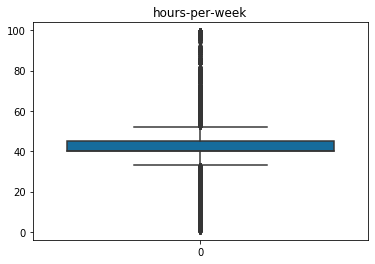

In [10]:
# теперь нужно понять в каких пределах возможны указания значений
# можно построить boxplot
for j in not_null_columns:
    plt.figure()
    plt.title(j)
    sns.boxplot(data=data[j])

In [11]:
# посмотрим какие крайности у нас есть в именованиях и\или значениях по каждому признаку
for j in data:
    uniq = np.unique(data[j].values)
    print(j+": "+str(len(uniq))+"\n"+str(uniq)+"\n")

age: 73
[17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40
 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64
 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88
 90]

workclass: 9
['?' 'Federal-gov' 'Local-gov' 'Never-worked' 'Private' 'Self-emp-inc'
 'Self-emp-not-inc' 'State-gov' 'Without-pay']

education: 16
['10th' '11th' '12th' '1st-4th' '5th-6th' '7th-8th' '9th' 'Assoc-acdm'
 'Assoc-voc' 'Bachelors' 'Doctorate' 'HS-grad' 'Masters' 'Preschool'
 'Prof-school' 'Some-college']

education-num: 16
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]

marital-status: 7
['Divorced' 'Married-AF-spouse' 'Married-civ-spouse'
 'Married-spouse-absent' 'Never-married' 'Separated' 'Widowed']

occupation: 15
['?' 'Adm-clerical' 'Armed-Forces' 'Craft-repair' 'Exec-managerial'
 'Farming-fishing' 'Handlers-cleaners' 'Machine-op-inspct' 'Other-service'
 'Priv-house-serv' 'Prof-specialty' 'Protective-serv' 'Sales'
 'Tech-support' 'Transpo

In [12]:
# и выпишем все подозрительности:
to_review = []
to_review.append(["age", 17]) # adult > 18, не поправить, дропаем
to_review.append(["occupation", "?"]) # скорее всего удалить, усреднять не вижу смысла, other уже есть
to_review.append(["workclass", "?"]) # а вот кем работает можно пометить как "other", без удаления
to_review.append(["capital-gain", 0]) # будем подделывать, тут ошибки заполнения
to_review.append(["capital-gain", 99999]) # тут скорее всего врали, посмотрим на количество, может тоже подделаем
to_review.append(["capital-loss", 0]) # видимо тоже надо будет подделывать, посмотрим 
to_review.append(["native-country", "?"]) # можно заменить на other, а можно дропнуть, посмотрим на количество

# так же есть подозрение что "educaton" и "educaton_num" это одно и то же, в разных кодировках

for j in to_review:
    print(j, (data[j[0]] == j[1]).sum())
data.shape

['age', 17] 395
['occupation', '?'] 1843
['workclass', '?'] 1836
['capital-gain', 0] 29849
['capital-gain', 99999] 159
['capital-loss', 0] 31042
['native-country', '?'] 583


(32561, 14)

In [13]:
#  to_review.append(["age", 17]) # adult > 18, не поправить, дропаем
data = data[data["age"] >= 18]
for j in to_review:
    print(j, (data[j[0]] == j[1]).sum())
data.shape

['age', 17] 0
['occupation', '?'] 1778
['workclass', '?'] 1772
['capital-gain', 0] 29464
['capital-gain', 99999] 159
['capital-loss', 0] 30657
['native-country', '?'] 581


(32166, 14)

In [14]:
# to_review.append(["occupation", "?"]) # скорее всего удалить, усреднять не вижу смысла, other уже есть
data = data[data["occupation"] != "?"]
for j in to_review:
    print(j, (data[j[0]] == j[1]).sum())
data.shape

['age', 17] 0
['occupation', '?'] 0
['workclass', '?'] 0
['capital-gain', 0] 27807
['capital-gain', 99999] 155
['capital-loss', 0] 28937
['native-country', '?'] 554


(30388, 14)

In [15]:
# to_review.append(["workclass", "?"]) # а вот кем работает можно пометить как "other", без удаления
# но после очистки от неусредняемого класса "occupation", таких осталось 0 экземпляров на датасет
# даже если бы было немного больше, проще было бы удалить
data = data[data["workclass"] != "?"]
for j in to_review:
    print(j, (data[j[0]] == j[1]).sum())
data.shape

['age', 17] 0
['occupation', '?'] 0
['workclass', '?'] 0
['capital-gain', 0] 27807
['capital-gain', 99999] 155
['capital-loss', 0] 28937
['native-country', '?'] 554


(30388, 14)

In [16]:
# to_review.append(["capital-gain", 0]) # будем подделывать, тут ошибки заполнения
# нет, не будем. 91.5% записей с нулями. надо выкидывать.
data.drop("capital-gain", axis=1, inplace=True)
to_review.remove(['capital-gain', 0])
to_review.remove(['capital-gain', 99999])
# to_review.append(["capital-gain", 99999]) # тут скорее всего врали, посмотрим на количество, может тоже подделаем
# to_review.append(["capital-loss", 0]) # видимо тоже надо будет подделывать, посмотрим 
# тоже дропаем, практически все значения (>90%) одинаковые и = 0
data.drop("capital-loss", axis=1, inplace=True)
to_review.remove(['capital-loss', 0])

for j in to_review:
    print(j, (data[j[0]] == j[1]).sum())
data.shape

['age', 17] 0
['occupation', '?'] 0
['workclass', '?'] 0
['native-country', '?'] 554


(30388, 12)

In [17]:
# to_review.append(["native-country", "?"]) # можно заменить на other, а можно дропнуть, посмотрим на количество
# дропать не будем, заменим на какую-нибудь страну "Other"
data["native-country"].replace("?", "Other", inplace=True)
for j in to_review:
    print(j, (data[j[0]] == j[1]).sum())
data.shape

['age', 17] 0
['occupation', '?'] 0
['workclass', '?'] 0
['native-country', '?'] 0


(30388, 12)

In [18]:
# еще раз смотрим, все ли значения нас устраивают:
for j in data:
    uniq = np.unique(data[j].values)
    print(j+": "+str(len(uniq))+"\n"+str(uniq)+"\n")

age: 71
[18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65
 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 88 90]

workclass: 7
['Federal-gov' 'Local-gov' 'Private' 'Self-emp-inc' 'Self-emp-not-inc'
 'State-gov' 'Without-pay']

education: 16
['10th' '11th' '12th' '1st-4th' '5th-6th' '7th-8th' '9th' 'Assoc-acdm'
 'Assoc-voc' 'Bachelors' 'Doctorate' 'HS-grad' 'Masters' 'Preschool'
 'Prof-school' 'Some-college']

education-num: 16
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]

marital-status: 7
['Divorced' 'Married-AF-spouse' 'Married-civ-spouse'
 'Married-spouse-absent' 'Never-married' 'Separated' 'Widowed']

occupation: 14
['Adm-clerical' 'Armed-Forces' 'Craft-repair' 'Exec-managerial'
 'Farming-fishing' 'Handlers-cleaners' 'Machine-op-inspct' 'Other-service'
 'Priv-house-serv' 'Prof-specialty' 'Protective-serv' 'Sales'
 'Tech-support' 'Transport-moving']

relationship: 6
[

In [19]:
# уже лучше. проверим, совпадают ли "education" и "education-num"
for j in sorted(data["education-num"].unique()):
    print(str(j)+" -> "+str(data[data["education-num"] == j]["education"].unique()))

1 -> ['Preschool']
2 -> ['1st-4th']
3 -> ['5th-6th']
4 -> ['7th-8th']
5 -> ['9th']
6 -> ['10th']
7 -> ['11th']
8 -> ['12th']
9 -> ['HS-grad']
10 -> ['Some-college']
11 -> ['Assoc-voc']
12 -> ['Assoc-acdm']
13 -> ['Bachelors']
14 -> ['Masters']
15 -> ['Prof-school']
16 -> ['Doctorate']


In [20]:
# видно что каждому значению "education-num" соответствует единственное значение "education"
# будем заниматься энкодингом, поэтому что-то нужно дропнуть
# т.к. избыточное дублирование существующей информации
# для OHE удобнее дропнуть "education-num" чтобы проще интерпретировать
# но OHE сюда не подходит - слишком сильно увеличится размерность данных
# при этом "education" выглядит как результат OrdinalEncoder("education-num")
# можем оставить, но хочется поперекодировать руками
# для этого датасета мне нравится Target Encoder, дает вероятность категории на предоставленной выборке
# посему прямо сейчас дропаем "education-num" 
# и немного позже будем делать TargetEncoding("education"), поскольку потребуется делить данные

data.drop("education-num", axis=1, inplace=True)
data.tail()

,age,workclass,education,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,makes_over_50K_a_year
32556,27,Private,Assoc-acdm,Married-civ-spouse,Tech-support,Wife,White,Female,38,United-States,<=50K
32557,40,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,40,United-States,>50K
32558,58,Private,HS-grad,Widowed,Adm-clerical,Unmarried,White,Female,40,United-States,<=50K
32559,22,Private,HS-grad,Never-married,Adm-clerical,Own-child,White,Male,20,United-States,<=50K
32560,52,Self-emp-inc,HS-grad,Married-civ-spouse,Exec-managerial,Wife,White,Female,40,United-States,>50K


In [21]:
# а пока что OHE, есть пара удобных атрибутов 
# уже существующие бинарные параметры меняем с помощью lambda-функции:
#
# sex: 2
# ['Female' 'Male']
#
# makes_over_50K_a_year: 2
# ['<=50K' '>50K']

data["sex"] = data["sex"].apply(lambda x: 1 if x=='Male' else 0)
data["makes_over_50K_a_year"] = data["makes_over_50K_a_year"].apply(lambda x: 1 if x=='>50K' else 0)
data.tail()

,age,workclass,education,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,makes_over_50K_a_year
32556,27,Private,Assoc-acdm,Married-civ-spouse,Tech-support,Wife,White,0,38,United-States,0
32557,40,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,1,40,United-States,1
32558,58,Private,HS-grad,Widowed,Adm-clerical,Unmarried,White,0,40,United-States,0
32559,22,Private,HS-grad,Never-married,Adm-clerical,Own-child,White,1,20,United-States,0
32560,52,Self-emp-inc,HS-grad,Married-civ-spouse,Exec-managerial,Wife,White,0,40,United-States,1


In [22]:
# посмотрим что OHE хорошо все перекодировал
for j in data:
    uniq = np.unique(data[j].values)
    print(j+": "+str(len(uniq))+"\n"+str(uniq)+"\n")

age: 71
[18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65
 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 88 90]

workclass: 7
['Federal-gov' 'Local-gov' 'Private' 'Self-emp-inc' 'Self-emp-not-inc'
 'State-gov' 'Without-pay']

education: 16
['10th' '11th' '12th' '1st-4th' '5th-6th' '7th-8th' '9th' 'Assoc-acdm'
 'Assoc-voc' 'Bachelors' 'Doctorate' 'HS-grad' 'Masters' 'Preschool'
 'Prof-school' 'Some-college']

marital-status: 7
['Divorced' 'Married-AF-spouse' 'Married-civ-spouse'
 'Married-spouse-absent' 'Never-married' 'Separated' 'Widowed']

occupation: 14
['Adm-clerical' 'Armed-Forces' 'Craft-repair' 'Exec-managerial'
 'Farming-fishing' 'Handlers-cleaners' 'Machine-op-inspct' 'Other-service'
 'Priv-house-serv' 'Prof-specialty' 'Protective-serv' 'Sales'
 'Tech-support' 'Transport-moving']

relationship: 6
['Husband' 'Not-in-family' 'Other-relative' 'Own-child' 'Unmarried' 'W

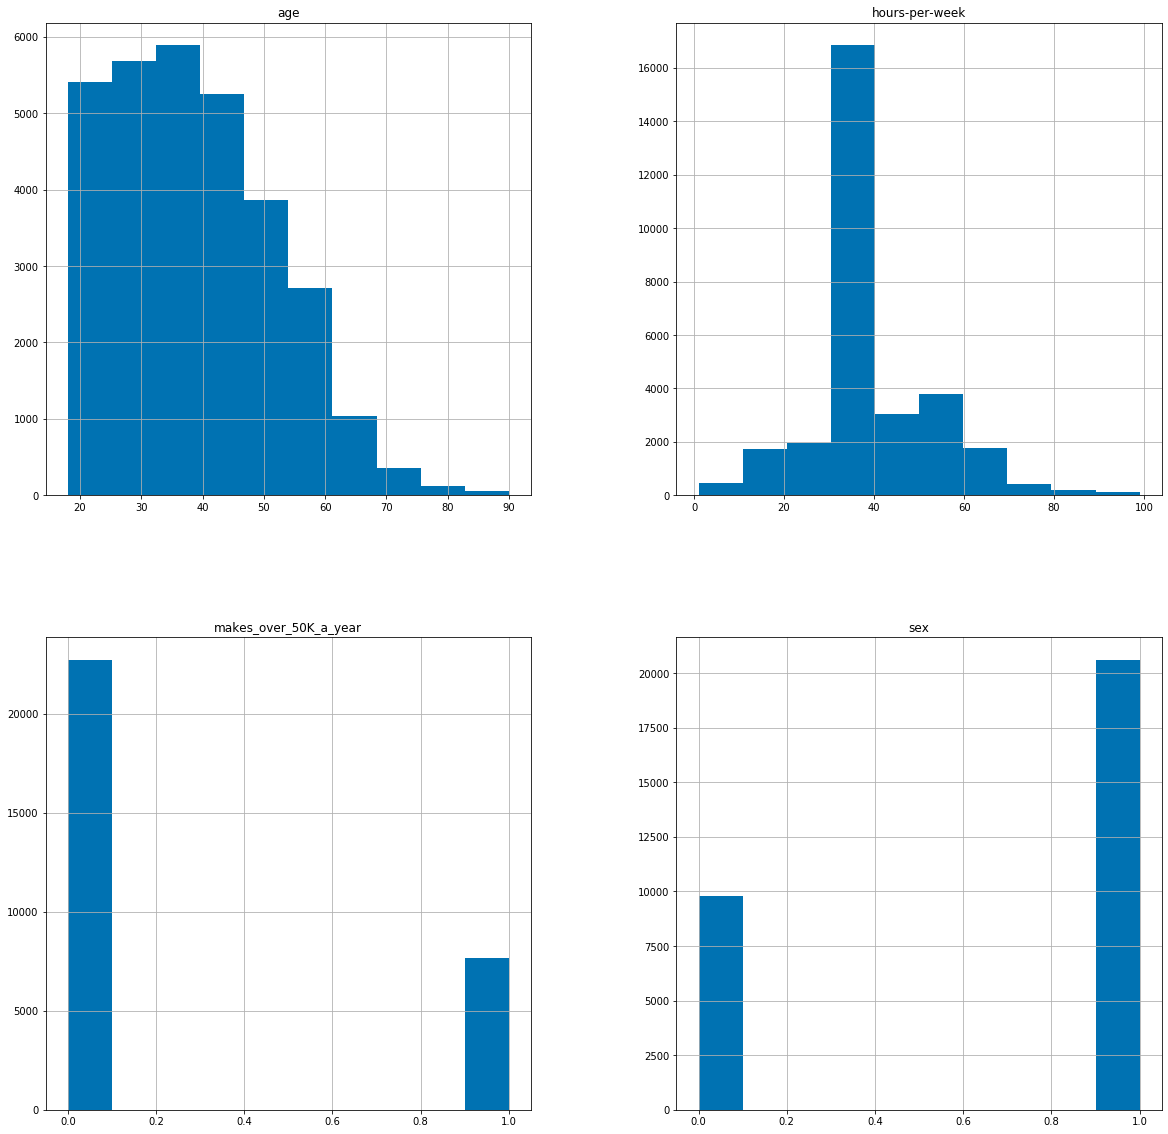

In [23]:
# теперь посмотрим на гистограммы и выбросы по имеющимся цифрам
data.hist(figsize=(20,20));

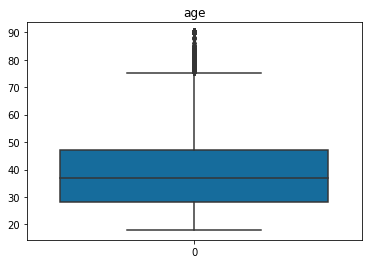

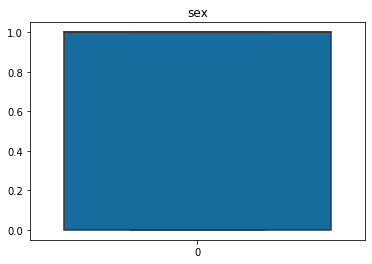

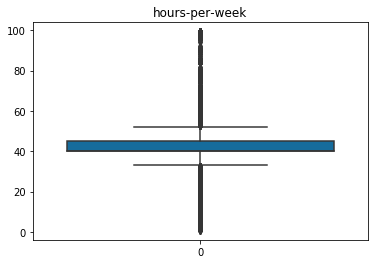

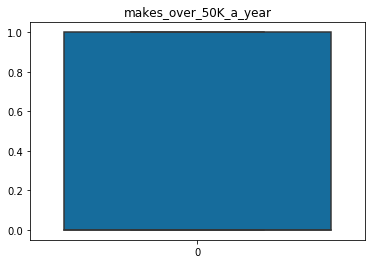

In [24]:
# посмотрим на boxplot
for j in data.loc[:, data.dtypes != np.object].columns.values:
    plt.figure()
    plt.title(j)
    sns.boxplot(data=data[j])

In [25]:
# отлично, можем смотреть на "age" и "hours-per-week"
# ищем выбросы
# варианты: 
# - границы в абсолютных значениях
# - интерквартильное расстояние (IQR)
# - cреднее-среднеквадратичное отклонение 
# - Медианы абсолютного отклонения (MAD)
# сегодня мне нравится интерквартильное расстояние, хотя на практике стоит перебрать все варианты.

# опять пришлось модифицировать предложенную формулу
def outlier_detect_IQR(data,col,threshold=3):    
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    Lower_fence = data[col].quantile(0.25) - (IQR * threshold)
    Upper_fence = data[col].quantile(0.75) + (IQR * threshold)
    para = (Upper_fence, Lower_fence)
    tmp = pd.concat([data[col]>Upper_fence,data[col]<Lower_fence],axis=1)
    outlier_index = tmp.any(axis=1)
    #print('Количество выбросов в данных:', outlier_index.value_counts()[1])
    # везде outlier_index.value_counts()[1] -> outlier_index.sum()
    print('Количество выбросов в данных:', outlier_index.sum())
    print('Доля выбросов:', outlier_index.sum()/len(data)) # и тут на ноль больше не делим
    return outlier_index, para

# для возраста
index,para = outlier_detect_IQR(data=data,col="age",threshold=3)
print('Верхняя граница:', para[0],'\nНижняя граница:',para[1])


Количество выбросов в данных: 0
Доля выбросов: 0.0
Верхняя граница: 104.0 
Нижняя граница: -29.0


In [26]:
# по "age" сильных выбросов нет, не трогаем
# по "hours-per-week": threshold=3 дает много выбросов:
#
# Количество выбросов в данных: 3557
# Доля выбросов: 0.11705278399368171
# Верхняя граница: 60.0 
# Нижняя граница: 25.0
#
# поэтому будем расширять /// либо надо использовать другой способ

# для часов в неделю
index,para = outlier_detect_IQR(data=data,col="hours-per-week",threshold=6) 
print('Верхняя граница:',para[0],'\nНижняя граница:',para[1])
print(data.shape)

# запишем в новую переменную
data_iqr = data.drop(data.loc[index].index)

Количество выбросов в данных: 610
Доля выбросов: 0.02007371330788469
Верхняя граница: 75.0 
Нижняя граница: 10.0
(30388, 11)


In [27]:
# дропнули нужные значения?
print(data_iqr.shape)

(29778, 11)


In [28]:
# Ok, поскольку непрерывные атрибуты потрогали, теперь можно в энкодинг вот этих атрибутов
objects = data_iqr.loc[:, data_iqr.dtypes == np.object]
objects.tail(5)

,workclass,education,marital-status,occupation,relationship,race,native-country
32556,Private,Assoc-acdm,Married-civ-spouse,Tech-support,Wife,White,United-States
32557,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,United-States
32558,Private,HS-grad,Widowed,Adm-clerical,Unmarried,White,United-States
32559,Private,HS-grad,Never-married,Adm-clerical,Own-child,White,United-States
32560,Self-emp-inc,HS-grad,Married-civ-spouse,Exec-managerial,Wife,White,United-States


In [29]:
# Посмотрим на разнообразие:
object_classes = []
for j in objects.columns.values: 
    print(j+":", np.unique(data_iqr[j]).size)
    object_classes.append(j)

workclass: 7
education: 16
marital-status: 7
occupation: 14
relationship: 6
race: 5
native-country: 42


In [30]:
# Для OHE слишком велико разнообразие
# Из лекций знаем про Ordinal, Target, WOE
# для любого из них нужно бить датасет на train/test
# иначе в train попадет информация из теста
# и модель будет слишком оптимистичной
# - Ordinal для классификации мне не нравится
# - Target подходит лучше - вероятностное распределение по категориям в выборке
# - WOE хорош именно для logit, для каждой категории ln(hit/target)
# в нашем случае как раз логистическая регрессия, берем WOE

x_train, x_test, y_train, y_test = train_test_split(
    data_iqr.drop(["makes_over_50K_a_year"], axis=1), # кроме целевого значения
    data_iqr["makes_over_50K_a_year"], # только целевое значение, его предсказываем
    test_size=0.3, # 30% на тесты
    random_state=13, # повторяемая рандомность №13 (число произвольное)
    stratify=data_iqr["makes_over_50K_a_year"] # бьем чтобы в тест попало пропорциональное число с True/False
)

x_train.shape, x_test.shape

((20844, 10), (8934, 10))

In [31]:
# scaling https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html
# StandardScaler плох при выбросах, не приводит к одной шкале
# MinMaxScaler приводит к [0,1] но тоже плох при выбросах
# RobustScaler == StandartScaler только по интерквантильному расстоянию, а не по M/D
# В идеале нужно аккуратно причесать все выбросы и использовать scaler + transformer
# но выбросы уже убрали а про трансформеры не знаем
# в текущей задаче нужно скейлить два параметра: "age", "hours-per-week"

# age
uniq = np.unique(data_iqr["age"].values)
print("age"+": "+str(len(uniq))+"\n"+str(uniq)+"\n")
# hours-per-week
uniq = np.unique(data_iqr["hours-per-week"].values)
print("hours-per-week"+": "+str(len(uniq))+"\n"+str(uniq)+"\n")

age: 71
[18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65
 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 88 90]

hours-per-week: 64
[10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33
 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57
 58 59 60 61 62 63 64 65 66 67 68 70 72 73 74 75]



In [32]:
# это примерно одинаковые шкалы, с убранными выбросами и с похожими boxplot'ами
# можно пробовать StandardScaler на обеих
x_train_scaled = x_train.copy(deep=True)
x_test_scaled = x_test.copy(deep=True)
age_scaler = StandardScaler().fit(x_train[["age"]])
hpw_scaler = StandardScaler().fit(x_train[["hours-per-week"]])

x_train_scaled["age"] = age_scaler.transform(x_train_scaled[["age"]])
x_train_scaled["hours-per-week"] = hpw_scaler.transform(x_train_scaled[["hours-per-week"]])

# # # # # # # # # # # # # # #
# вот тут все правильно? fit на train и transform на test?
x_test_scaled["age"] = age_scaler.transform(x_test_scaled[["age"]])
x_test_scaled["hours-per-week"] = hpw_scaler.transform(x_test_scaled[["hours-per-week"]])
# # # # # # # # # # # # # # #

x_train_scaled.tail()

,age,workclass,education,marital-status,occupation,relationship,race,sex,hours-per-week,native-country
13538,-0.824349,Private,10th,Never-married,Machine-op-inspct,Own-child,White,0,-0.099555,United-States
30710,-0.280616,Private,HS-grad,Divorced,Other-service,Not-in-family,White,0,-0.587842,United-States
14829,0.573821,Private,Assoc-voc,Divorced,Sales,Unmarried,White,0,-0.099555,United-States
13531,0.884525,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,1,-0.099555,United-States
12758,0.651497,Private,Masters,Married-civ-spouse,Adm-clerical,Wife,White,0,-0.294870,United-States


In [33]:
print(objects.columns.values)

['workclass' 'education' 'marital-status' 'occupation' 'relationship'
 'race' 'native-country']


In [34]:
# нормализовали числовые, теперь энкодинг категориальных
# уже определились что берем WOE

woe_enc = ce.WOEEncoder(cols=objects.columns.values).fit(x_train_scaled,y_train)
x_train_scaled = woe_enc.transform(x_train_scaled)
x_test_scaled = woe_enc.transform(x_test_scaled)
x_train_scaled.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,hours-per-week,native-country
12783,-1.290405,-0.175015,-1.927893,-1.819630,-0.105412,-0.996787,0.085538,1,-0.099555,-1.263733
19120,0.806849,-0.175015,-0.529195,0.900294,-0.105412,0.908941,0.085538,1,0.388732,0.030498
7231,-0.668996,-0.175015,-0.300280,-1.019241,0.142059,-3.138301,0.085538,1,-0.099555,0.030498
14166,1.272905,-0.175015,-0.529195,-1.019241,1.041952,-0.996787,0.085538,0,-0.099555,0.030498
23093,-1.212729,-0.175015,-0.300280,0.900294,0.142059,0.908941,0.085538,1,-0.099555,0.030498


In [35]:
x_test_scaled.tail()

,age,workclass,education,marital-status,occupation,relationship,race,sex,hours-per-week,native-country
23259,-0.746673,0.190240,-0.529195,0.900294,-0.105412,0.908941,0.085538,1,-0.392527,0.030498
23555,-1.368081,-0.175015,-0.300280,-1.819630,-0.330988,-3.138301,0.085538,1,-1.076130,0.030498
25199,-0.047588,-0.175015,-0.300280,-1.819630,-1.992450,-0.996787,0.085538,1,-0.099555,0.030498
12655,-0.202940,1.326053,-0.529195,0.900294,1.041952,0.908941,0.085538,1,0.877020,0.070491
4702,-1.601109,-0.175015,-0.529195,-1.819630,0.142059,-3.138301,0.085538,0,-2.540992,0.030498


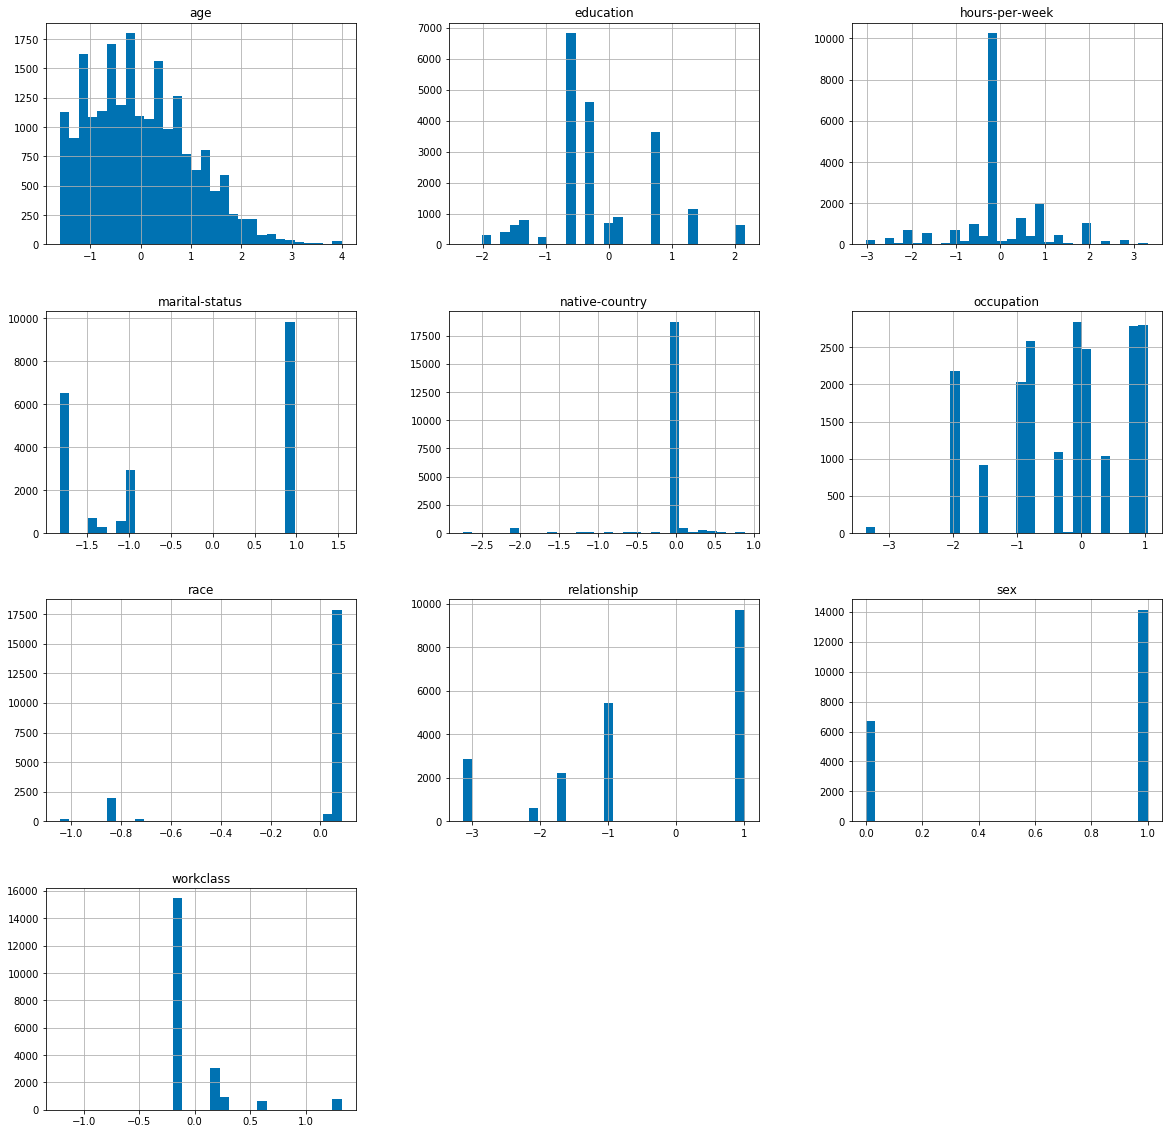

In [36]:
# теперь гистограммы и корреляции, должно быть интересно
x_train_scaled.hist(figsize=(20, 20), bins=30);

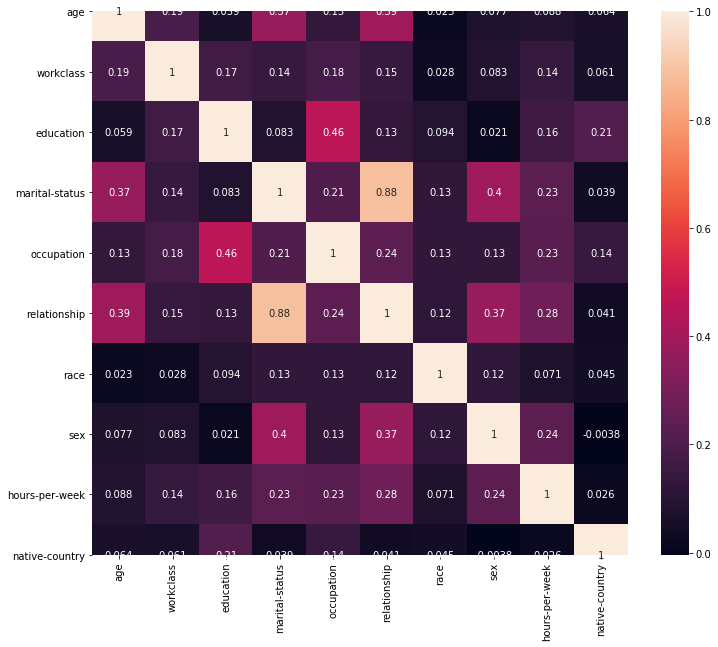

In [37]:
plt.figure(figsize=(12, 10))
sns.heatmap(x_train_scaled.corr(), annot=True);

In [38]:
# уже видно глазами, но посмотрим еще раз программно:
correlations = x_train_scaled.corr()
used_corr_index = []
interesting_corr_index=[]
for i in correlations:
    for j in correlations.index[correlations[i].abs() > 0.8]:
        # if i != j and i not in used_corr_index and j not in used_corr_index:
        if i != j and [i,j] not in used_corr_index and [j,i] not in used_corr_index:
        #if i != j and [i,j] not in used_corr_index:
            used_corr_index.append([i,j])
            print(correlations[i][correlations.index == j].values[0], "  ", i, "  ", j )
            interesting_corr_index.append([i,j,correlations[i][correlations.index == j].values[0]])


0.8844573620619649    marital-status    relationship


In [39]:
# для логистической регрессии высокие корреляции не подходят
# нужно дропнуть либо "marital-status" либо "relationship"

# пока не будем дропать

In [40]:
# посмотрим, есть ли константные признаки, которые слабо меняются:
def constant_feature_detect(data,threshold=0.98):    
    data_copy = data.copy(deep=True)
    quasi_constant_feature = []
    for feature in data_copy.columns:
        predominant = (data_copy[feature].value_counts() / np.float(
                      len(data_copy))).sort_values(ascending=False).values[0]
        if predominant >= threshold:
            quasi_constant_feature.append(feature)
    print(len(quasi_constant_feature),'константные переменные')    
    return quasi_constant_feature
quasi_constant_feature = constant_feature_detect(data=x_train_scaled,threshold=0.9)

0 константные переменные


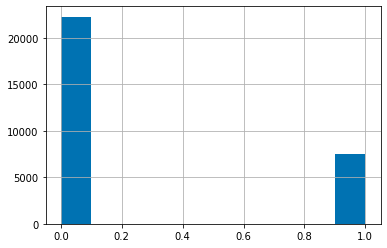

In [41]:
# посмотрим на целевую переменную, насколько сбалансированны классы
# можно смотреть на изначальный датасет, поскольку в таргете ничего не менялось
data_iqr["makes_over_50K_a_year"].hist()

In [42]:
data_iqr["makes_over_50K_a_year"].value_counts()


0    22274
1     7504
Name: makes_over_50K_a_year, dtype: int64

In [43]:
# дисбаланс сильный
# нужно 
# - либо выкинуть рандомно часть данных, но это за рамками лекции, не подходит (хотя я бы так и сделал)
# - либо undersampling на false, сильно уменьшая датасет
# https://imbalanced-learn.readthedocs.io/en/stable/under_sampling.html#controlled-under-sampling
# - либо oversampling на true, ухудшая репрезентативность данных искуственными значениями
# https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html#random-over-sampler
# мне не нравится забивание искуственными данными, будем делать undersampling
# хотя на практике нужно тестировать три варианта - без модификаций, с over, с under
cnn = CondensedNearestNeighbour(random_state=13)


In [44]:
# очень долго выполняется, сложность квадратичная - особенности алгоритма
x_train_scaled_res, y_train_res = cnn.fit_resample(x_train_scaled, y_train)


In [45]:
print(len(x_train_scaled_res))
np.array(np.unique(y_train_res, return_counts=True)).T

9266


array([[   0, 4013],
       [   1, 5253]])

/home/pbedyaev/anaconda2/envs/ml/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/pbedyaev/anaconda2/envs/ml/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


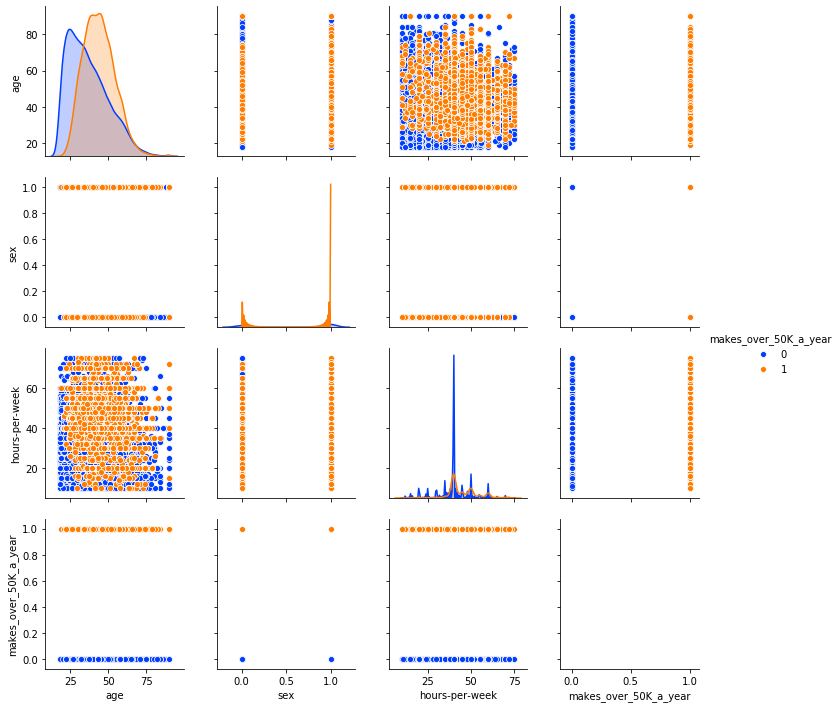

In [46]:
# для x/y _ test выборок resample можно не делать, они в обучении не участвуют
# pairplot для того что было, будем сравнивать с тем что наделали
sns.pairplot(data=data_iqr, hue="makes_over_50K_a_year", palette=("bright"))

/home/pbedyaev/anaconda2/envs/ml/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/pbedyaev/anaconda2/envs/ml/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


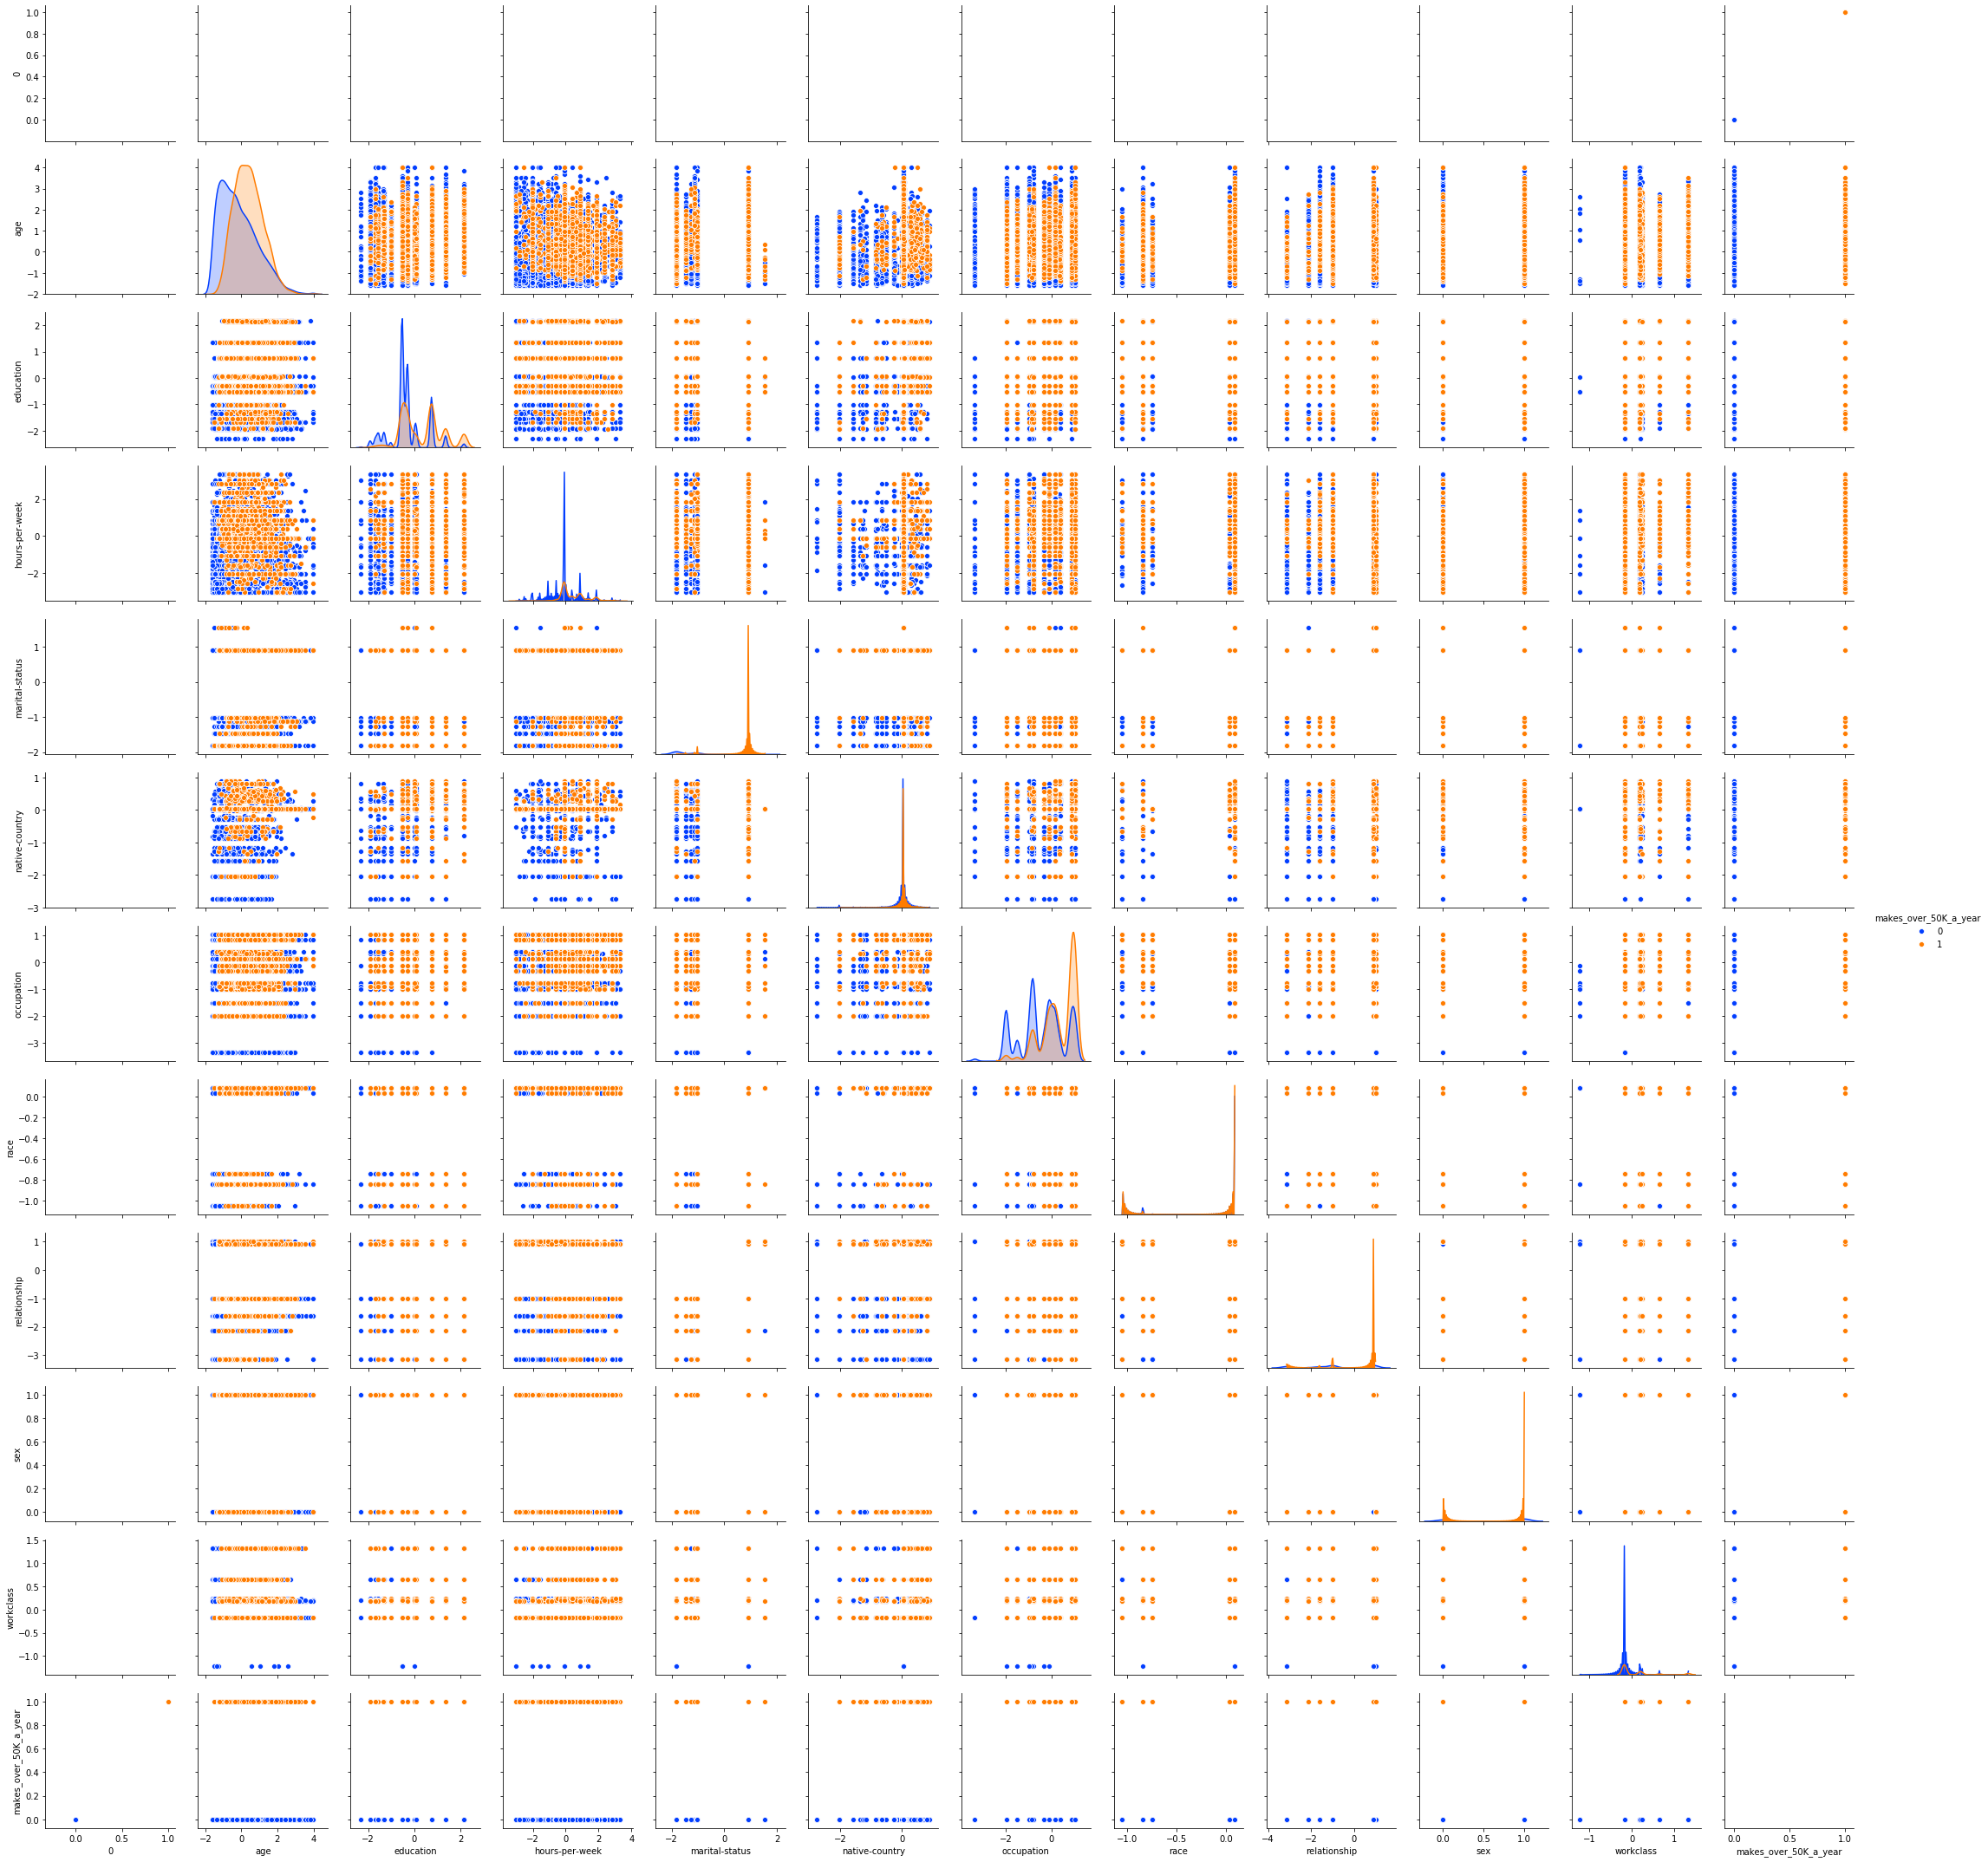

In [47]:
modifyed_data_iqr = pd.concat([x_train_scaled, y_train])
modifyed_data_iqr[y_train.name] = y_train
sns.pairplot(data=modifyed_data_iqr, hue="makes_over_50K_a_year", palette=("bright"))

In [48]:
# теперь регрессия
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

def quality_report(prediction, actual):
    print("Accuracy: {:.3f}\nPrecision: {:.3f}\nRecall: {:.3f}\nf1_score: {:.3f}".format(
        accuracy_score(prediction, actual),
        precision_score(prediction, actual),
        recall_score(prediction, actual),
        f1_score(prediction, actual)
    ))

In [49]:
log_reg = LogisticRegression()

log_reg.fit(x_train_scaled_res, y_train_res)
print("Train quality:")
quality_report(log_reg.predict(x_train_scaled_res), y_train_res)
print("\nTest quality:")
quality_report(log_reg.predict(x_test_scaled), y_test)

Train quality:
Accuracy: 0.687
Precision: 0.792
Recall: 0.698
f1_score: 0.742

Test quality:
Accuracy: 0.795
Precision: 0.802
Recall: 0.565
f1_score: 0.663


/home/pbedyaev/anaconda2/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


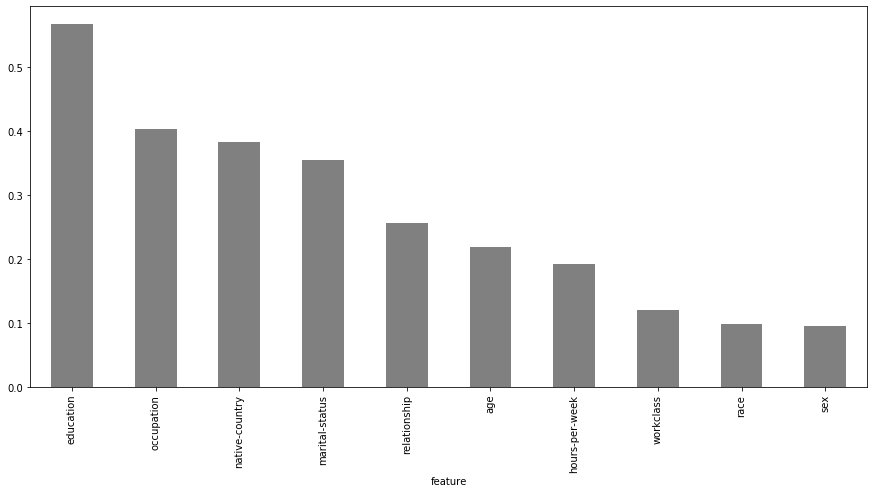

In [50]:
featureImportance = pd.DataFrame({"feature": data.drop("makes_over_50K_a_year",axis=1).columns, 
                                  "importance": log_reg.coef_[0]})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind='bar', figsize=(15, 7), color=("gray"));

In [51]:
# тут видно, что relationship влияет меньше чем marital-status, значит его можно убрать в дальнейшем
# 
from sklearn.metrics import roc_auc_score, roc_curve

def plot_roc_curve(prob_prediction, actual):
    fpr, tpr, thresholds = roc_curve(y_test, prob_prediction)
    auc_score = roc_auc_score(y_test, prob_prediction)
    
    plt.plot(fpr, tpr, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC: {:.3f}'.format(auc_score))
    plt.show()

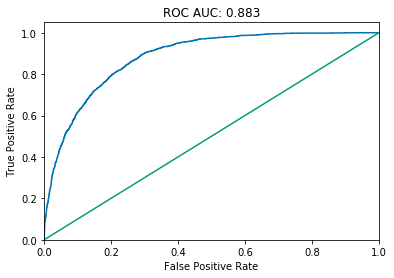

In [52]:
plot_roc_curve(log_reg.predict_proba(x_test_scaled)[:,1], y_test)

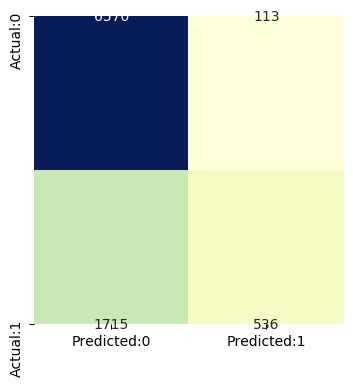

In [53]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, log_reg.predict_proba(x_test_scaled)[:, 1]>0.8)
plt.style.use('default')

conf_matrix = pd.DataFrame(data = cm, columns = ['Predicted:0','Predicted:1'], index=['Actual:0','Actual:1'])
plt.figure(figsize = (4,4))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu", cbar=False);

In [54]:
log_reg_default = LogisticRegression()

log_reg_default.fit(x_train_scaled, y_train)
print("Train quality:")
quality_report(log_reg_default.predict(x_train_scaled), y_train)
print("\nTest quality:")
quality_report(log_reg_default.predict(x_test_scaled), y_test)

Train quality:
Accuracy: 0.823
Precision: 0.533
Recall: 0.693
f1_score: 0.603

Test quality:
Accuracy: 0.827
Precision: 0.544
Recall: 0.703
f1_score: 0.613


/home/pbedyaev/anaconda2/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


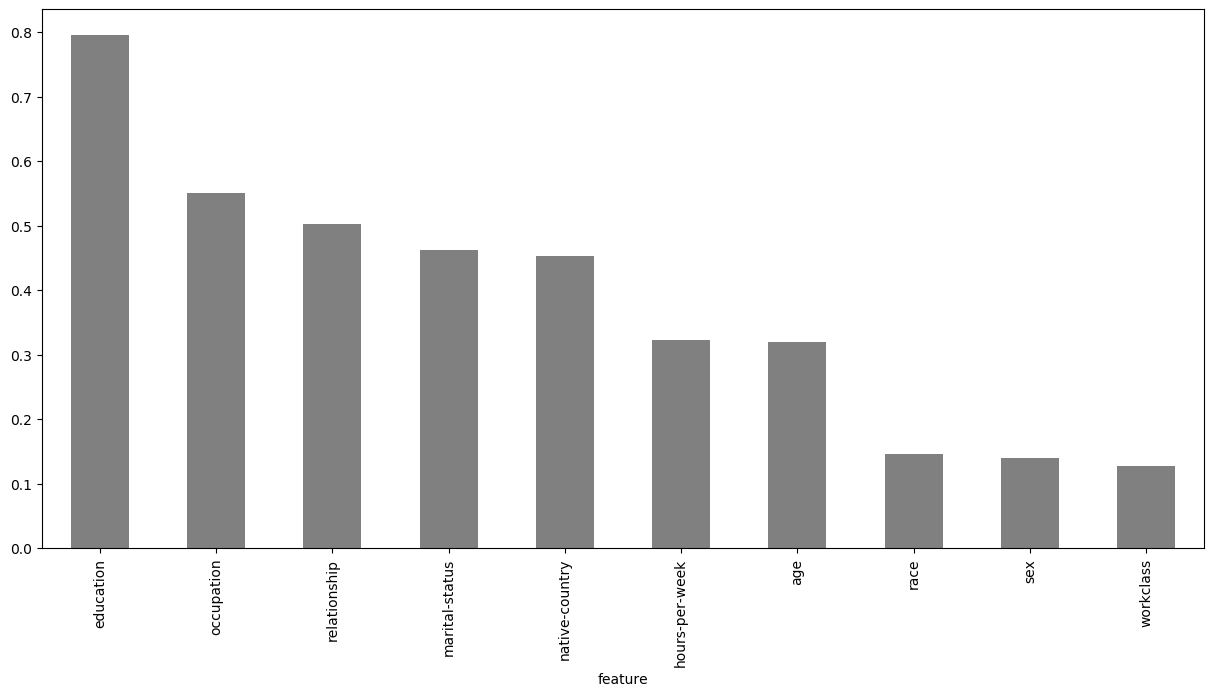

In [55]:
featureImportance = pd.DataFrame({"feature": data.drop("makes_over_50K_a_year",axis=1).columns, 
                                  "importance": log_reg_default.coef_[0]})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind='bar', figsize=(15, 7), color=("gray"));

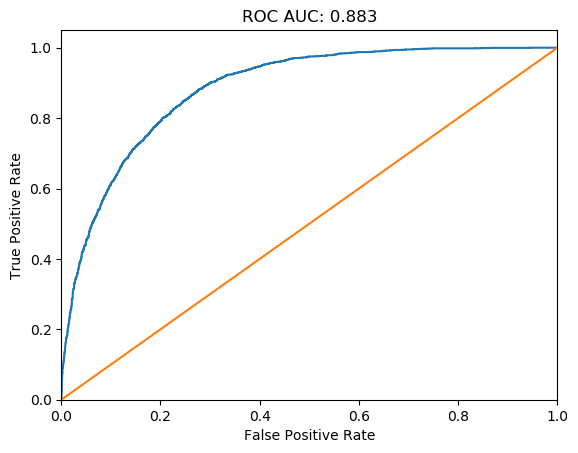

In [56]:
plot_roc_curve(log_reg_default.predict_proba(x_test_scaled)[:,1], y_test)

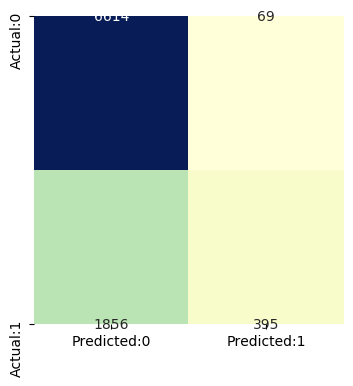

In [57]:
cm = confusion_matrix(y_test, log_reg_default.predict_proba(x_test_scaled)[:, 1]>0.8)
plt.style.use('default')

conf_matrix = pd.DataFrame(data = cm, columns = ['Predicted:0','Predicted:1'], index=['Actual:0','Actual:1'])
plt.figure(figsize = (4,4))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu", cbar=False);

In [58]:
# видно что без undersampling'a результаты немного хуже
# дальше можно убрать relationship/marital-status, подобрать более подходящий алгоритм undersampling'а
# или переключиться на oversampling
# и т.д. и т.п. 
#
# пока есть немного времени, дропну "relationship" и посмотрим как изменится модель
x_train_scaled_res, y_train_res = cnn.fit_resample(x_train_scaled.drop(["relationship"], axis=1), y_train)


In [63]:
log_reg = LogisticRegression()

log_reg.fit(x_train_scaled_res, y_train_res)
print("Train quality:")
quality_report(log_reg.predict(x_train_scaled_res), y_train_res)
print("\nTest quality:")
quality_report(log_reg.predict(x_test_scaled.drop(["relationship"], axis=1)), y_test)

Train quality:
Accuracy: 0.685
Precision: 0.786
Recall: 0.697
f1_score: 0.739

Test quality:
Accuracy: 0.796
Precision: 0.793
Recall: 0.568
f1_score: 0.662


/home/pbedyaev/anaconda2/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


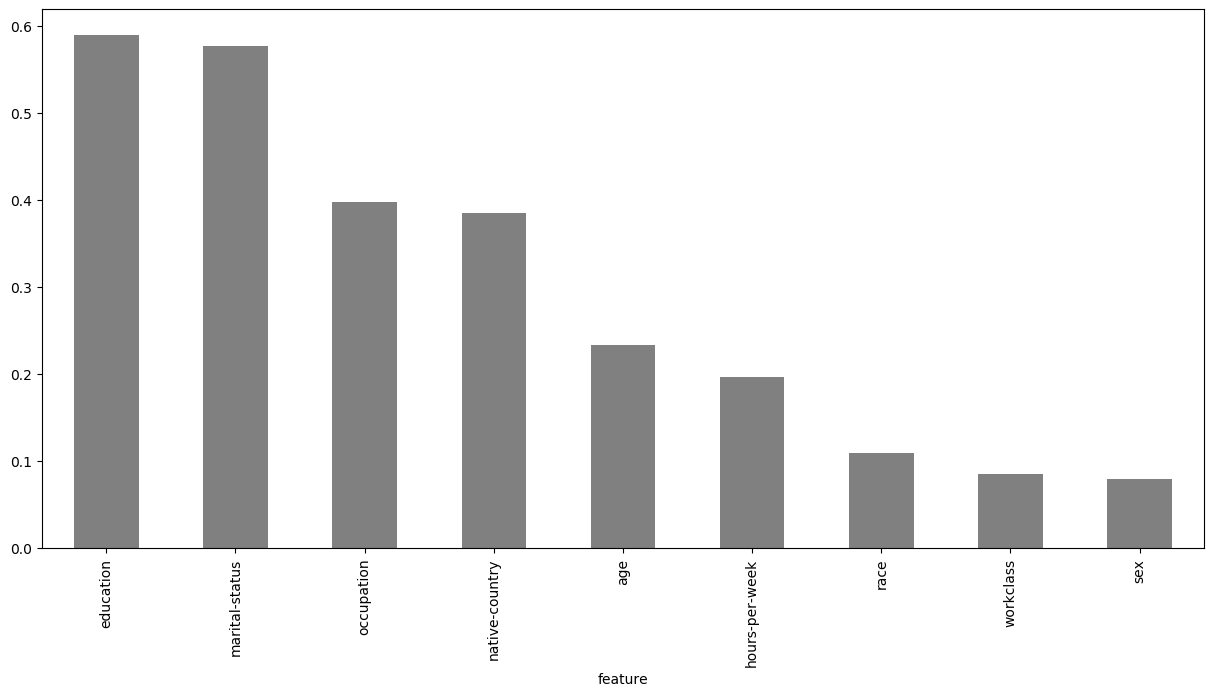

In [65]:
featureImportance = pd.DataFrame({"feature": data.drop(["makes_over_50K_a_year", "relationship"],axis=1).columns, 
                                  "importance": log_reg.coef_[0]})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot(kind='bar', figsize=(15, 7), color=("gray"));

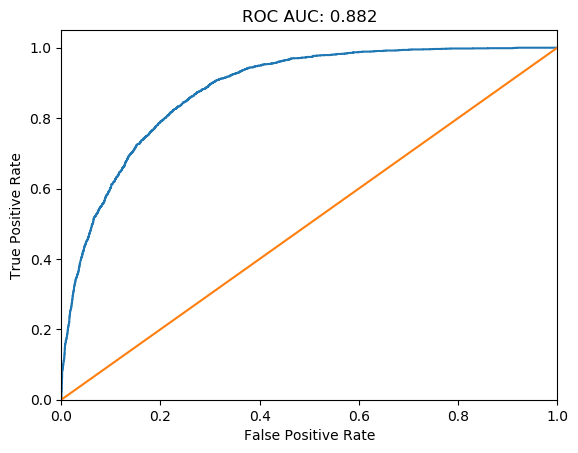

In [67]:
plot_roc_curve(log_reg.predict_proba(x_test_scaled.drop(["relationship"], axis=1))[:,1], y_test)

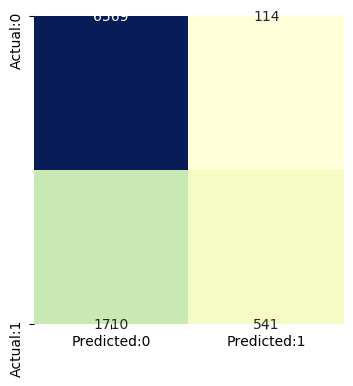

In [69]:
cm = confusion_matrix(y_test, log_reg.predict_proba(x_test_scaled.drop(["relationship"], axis=1))[:, 1]>0.8)
plt.style.use('default')

conf_matrix = pd.DataFrame(data = cm, columns = ['Predicted:0','Predicted:1'], index=['Actual:0','Actual:1'])
plt.figure(figsize = (4,4))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu", cbar=False);

In [70]:
# еще можно в кроссвалидацию, но такой задачи в домашке не ставилось